In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skewnorm
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import random
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import math
import torch.nn as nn
import copy
import nltk
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Hangman/
f = open("words_list.txt", "r")
df = []
for x in f:
  df.append(x)
for i in range(len(df)):
    df[i] = df[i].replace("\n", "")

print(df)


Output hidden; open in https://colab.research.google.com to view.

# EDA

English words usually contain vowels, so it will make sense to use them in the first guess

In [ ]:
#given length of a word, what is the probability that each vowel will appear?
vowels = ['a', 'e', 'i', 'o', 'u']
def vowel_count(word,vowel_dict):
    found = False
    if len(word) not in vowel_dict:
          vowel_dict.update({len(word):{}})
          vowel_dict[len(word)]={'a':0,'e':0,'i':0,'o':0,'u':0, 'None':0, 'Count':0}

    word_set=[i for i in word]
    word_set=set(word_set)
    for i in word_set:
        if i in vowels:
          found=True
          vowel_dict[len(word)][i]=vowel_dict[len(word)][i]+1

    vowel_dict[len(word)]['Count']=vowel_dict[len(word)]['Count']+1
    if not found:
        vowel_dict[len(word)]['None']=vowel_dict[len(word)]['None']+1

    return vowel_dict

vowel_dict = {}
for word in df:
    vowel_dict = vowel_count(word,vowel_dict)


#check if there is a word without vowels
cnt=0
for key, item in vowel_dict.items():
    cnt=cnt+vowel_dict[key]['None']

print(f"# words with out vowels: {cnt}")
word_length = [key for key in vowel_dict]
vowel_prob = []
for v in vowels:
  p = []
  for key in vowel_dict:
    p.append(vowel_dict[key][v]/vowel_dict[key]['Count'])
  vowel_prob.append(p)

p = []
for key in vowel_dict:
    p.append(vowel_dict[key]['None']/vowel_dict[key]['Count'])

vowel_prob.append(p)

# words with out vowels: 1249


1249/250,000 is not a lot- almost negligible. The strategy is sound. But what else can we use to guess the first letter?

The other info available is length:

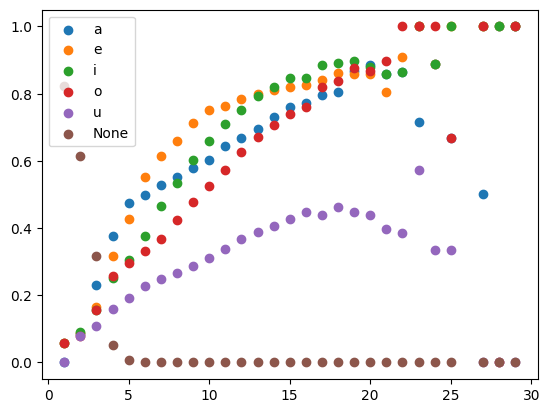

In [ ]:
#length-vowel relationship
plt.scatter(word_length,vowel_prob[0],label="a")
plt.scatter(word_length,vowel_prob[1],label="e")
plt.scatter(word_length,vowel_prob[2],label="i")
plt.scatter(word_length,vowel_prob[3],label="o")
plt.scatter(word_length,vowel_prob[4],label="u")
plt.scatter(word_length,vowel_prob[5],label="None")
plt.legend()
plt.show()

**Rudimentary Conclusion (Vowel & Length):**

0-5: guess o, u, a

5-10: guess e

10-15: guess i,e

15-20: guess i

20+: either o or i


# Stat Model + Transformer

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


def clone(layer, N):
    return nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])


def attention(query, key, value, mask=None, dropout=None):
    """
    query: shape (*, n_queries, d_k) n_queries is the maximum sentence length / max_sent_length - 1 if key from decoder
    key: (*, K, d_k) , K is the maximum sentence length / max_sent_length - 1 if key from decoder
    value: (*, K, d_v)

    scores: (n_quires, K)
    output: (n_queries, d_v)
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -np.inf)
    p = F.softmax(scores, dim=-1)
    if dropout is not None:
        p = dropout(p)

    return torch.matmul(p, value), p


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, d_k, d_v, dropout):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.h = h
        self.d_model = d_model
        self.query_linear = nn.Linear(in_features=d_k * h,
                                      out_features=d_model,
                                      bias=False)
        self.key_linear = nn.Linear(in_features=d_k * h,
                                    out_features=d_model,
                                    bias=False)
        self.value_linear = nn.Linear(in_features=d_v * h,
                                      out_features=d_model,
                                      bias=False)

        self.attn = None  # not used for computation, only for visualization
        self.dropout = nn.Dropout(p=dropout)

        self.output_linear = nn.Linear(in_features=d_model,
                                       out_features=h * d_v)

    def forward(self, query, key, value, mask=None):
        """
        d_k * h = d_model

        query: shape (batch_size, max_sent_length, embedding_size), d_model is the embedding size,
        key: shape (batch_size, max_sent_length, embedding_size), d_model is the embedding size
        value: shape (batch_size, max_sent_length, embedding_size), d_model is the embedding size,

        output: shape (batch_size, max_sent_length, embedding_size)
        """
        if mask is not None:
            mask = mask.unsqueeze(1)

        d_k = self.d_model // self.h

        n_batches = query.size(0)
        max_sent_length = query.size(1)
        query = self.query_linear(query).view(n_batches, max_sent_length, self.h, d_k).transpose(1, 2)
        key = self.key_linear(key).view(n_batches, key.size(1), self.h, d_k).transpose(1, 2)
        value = self.value_linear(value).view(n_batches, value.size(1), self.h, d_k).transpose(1, 2)

        # scores shape: (batch_size, h, max_sent_length, d_k)
        scores, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # concat attention scores over multiple heads
        # (batch_size, max_sent_length, d_model)
        scores = scores.transpose(1, 2).contiguous().view(n_batches, max_sent_length, self.h * d_k)

        return self.output_linear(scores)


class Generator(nn.Module):
    def __init__(self, d_model, vocab_size, max_len):
        super(Generator, self).__init__()
        self.linear = nn.Linear(in_features=d_model,
                                out_features=vocab_size)
        self.embed = torch.nn.Embedding(2,1)
        self.max_len=max_len
        self.pos_importance = nn.Linear(in_features=max_len,
                                out_features=max_len)
        self.relu = torch.nn.ReLU()
    def forward(self, x, src, exist_mask):

        #exist mask: BS,28-> BS,45,28
        # src: BS, 45-> BS, 45
        src = src!=0
        src = src.long()
        src = self.embed(src) #BS, 45, 1
        weight = self.relu(self.pos_importance(src.transpose(1,2))).transpose(1,2) #BS,45,1
        exist_mask = exist_mask.unsqueeze(1)
        exist_mask = exist_mask.repeat(1,self.max_len,1)

        x = self.linear(x)
        #x shape is BS,45,28
        #at each letter position, zero out the non candidates
        x = x.masked_fill_(exist_mask == 0, -1e9)
        x = F.log_softmax(x, dim=-1)
        x = torch.exp(x) #BS, 45, 28
        x = x.transpose(1,2) #BS, 28, 45

        #sum log probability at dim 1 with weights: BS, 28, 45 X 45, 1-> BS, 28, 1
        x = torch.matmul(x,weight)

        x = x.squeeze(-1)

        #output log_softmax logit
        x = F.log_softmax(x, dim=-1)

        # x = self.sum_para(torch.transpose(x,1,2))
        # x = x.squeeze(-1)

        #BS,28 -> BS,28
        # x = x.masked_fill_(exist_mask == 0, -1e9)
        # result = result.masked_fill_(exist_mask == 0, -1e9)
        # result, _ = torch.max(self.linear(x), dim=1)

        # result = result.masked_fill_(exist_mask == 0, -1e9)
        return F.log_softmax(x, dim=-1)


class SublayerSkipConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerSkipConnection, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = LayerNorm(size)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.layer_norm(x)))

class Encoder(nn.Module):
    def __init__(self, self_attn, feed_forward, size, dropout):
        super(Encoder, self).__init__()
        self.sub_layers = clone(SublayerSkipConnection(size, dropout), 2)
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.size = size

    def forward(self, x, mask):
        x = self.sub_layers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sub_layers[1](x, self.feed_forward)


class FullyConnectedFeedForward(nn.Module):
    """
    A fully connected neural network with Relu activation
    input: d_model
    hidden: d_ff
    output: d_model

    Implements FFN equation.
    FFN(x) = max(0, xW_1 + b)W_2 + b

    It consist of two linear layer and a Relu activation in between

    Linear_2(Relu(Linear_1(x))))
    """

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FullyConnectedFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """

        :param x: shape (batch_size, max_sent_len, embedding_size/d_model)
        :return: output: shape (batch_size, max_sent_len, embedding_size/d_model)
        """
        return self.w_2(self.dropout(F.gelu(self.w_1(x))))

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)



class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class Bert(nn.Module):
    def __init__(self, encoder: nn.Module, generator, embedding, n_layers: int):
        """

        :param encoder: encoder/transformer layer that takes advantage of self-attention
        :param n_layers: int, number of encoder/transformer layers
        """
        super(Bert, self).__init__()
        self.encoder = encoder
        self.layers = clone(encoder, n_layers)
        self.embed = embedding
        self.layer_norm = LayerNorm(encoder.size)
        self.generator = generator

    def forward(self, x: torch.Tensor, src_mask: torch.Tensor, candidates: torch.Tensor):
        """
        :param x: shape (batch_size, max_word_length)
        :param src_mask
        :return:
        """
        src = x
        x = self.embed(x)
        for layer in self.layers:
            x = layer(x, src_mask)

        x = self.layer_norm(x)
        x = self.generator(x=x,src=src,exist_mask=candidates)

        return x

    @property
    def device(self):
        return self.generator.linear.weight.device



d_model = 256
d_ff = 1024
h = 4
n_encoders = 4
max_len = 45
batch_size = 128
vocab_size = 28


self_attn = MultiHeadedAttention(h=h, d_model=d_model, d_k=d_model // h, d_v=d_model // h, dropout=0.1)
feed_forward = FullyConnectedFeedForward(d_model=d_model, d_ff=d_ff)
position = PositionalEncoding(d_model, dropout=0.1,max_len=max_len)
embedding = nn.Sequential(Embeddings(d_model=d_model, vocab_size=vocab_size), position)

encoder = Encoder(self_attn=self_attn, feed_forward=feed_forward, size=d_model, dropout=0.1)
generator = Generator(d_model=d_model, vocab_size=vocab_size,max_len=max_len)
model = Bert(encoder=encoder, embedding=embedding, generator=generator, n_layers=n_encoders)

model.load_state_dict(torch.load("model-8.pt",map_location=torch.device('cpu')))
model.eval()

<ipython-input-21-1463fd187967>:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model-8.pt",map_location=torch.device('cpu')))


Bert(
  (encoder): Encoder(
    (sub_layers): ModuleList(
      (0-1): 2 x SublayerSkipConnection(
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm()
      )
    )
    (self_attn): MultiHeadedAttention(
      (query_linear): Linear(in_features=256, out_features=256, bias=False)
      (key_linear): Linear(in_features=256, out_features=256, bias=False)
      (value_linear): Linear(in_features=256, out_features=256, bias=False)
      (dropout): Dropout(p=0.1, inplace=False)
      (output_linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (feed_forward): FullyConnectedFeedForward(
      (w_1): Linear(in_features=256, out_features=1024, bias=True)
      (w_2): Linear(in_features=1024, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (layers): ModuleList(
    (0-3): 4 x Encoder(
      (sub_layers): ModuleList(
        (0-1): 2 x SublayerSkipConnection(
          (dropout): Dropout(p=0.1, inplace=False

In [ ]:
#find max prob:
def max_prob(d, guessed):
  max_prob = 0
  letter = ""
  for key in d:
      if max_prob<d[key] and key not in guessed:
        letter=key
        max_prob=d[key]

  return letter

def get_char_mapping():
    #create mapping e.g. _: 1, #: 0
    char2id = dict()
    char2id['_'] = 1
    char2id['#'] = 0
    char_list = string.ascii_lowercase
    for i, c in enumerate(char_list):
        char2id[c] = len(char2id)

    return char2id

def encode_input(word, max_len):
    char_mapping = get_char_mapping()
    while len(word)<max_len:
        word=word+"#"
    word_vector = []
    for letter_no in word:
        word_vector.append(char_mapping[letter_no])
    return word_vector
class Game:
  def __init__(self,df, test,model):
    self.guessed_letters = []
    self.full_dictionary = df
    self.test = test
    self.model=model
    self.max_len = 45
    self.alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    self.char_mapping = get_char_mapping()
    self.id2char = {v: k for k, v in self.char_mapping.items()}
    self.alphabet_dict = {}
    for i in range(len(self.alphabet)):
          self.alphabet_dict.update({self.alphabet[i]:i})

    self.alphabet_dict["_"]=26

    self.model = model

    self.vowel = ['a','e','i','o','u']
    self.by_length = {}
    for word in self.full_dictionary:
      if len(word) not in self.by_length:
        self.by_length.update({len(word):[word]})
      else:
        self.by_length[len(word)].append(word)

    self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()


  def compute_freq_given_length(self,subset_d):
    full_dictionary_common_letter_sorted = collections.Counter("".join(subset_d)).most_common()
    letter_freq = [0 for i in range(26)]

    for pair in full_dictionary_common_letter_sorted:
      letter_freq[self.alphabet_dict[pair[0]]]=pair[1]/len(subset_d)

    return torch.tensor(letter_freq)

  def reveal(self,new_word, word,guess):
    correct = False
    new_word_cp = ""
    for i in range(len(word)):
      if word[i]==guess:
        new_word_cp=new_word_cp+guess
        correct = True
      else:
        new_word_cp=new_word_cp+new_word[i]

    return new_word_cp, correct
  def play(self):
    success = 0
    print(len(self.test))
    for word in self.test:
      new_word=""
      for letter in word:
        new_word=new_word+"_"

      trial = 6
      while trial >=0:
        if "_" not in new_word:
          break
        result = self.guess(new_word)
        self.guessed_letters.append(result)
        new_word, correct = self.reveal(new_word, word,result)
        print(new_word,result)
        if not correct:
          trial = trial - 1


      print(new_word)
      if "_" not in new_word:
        success=success+1
      print(word,success)
      self.guessed_letters = []



    return success/len(self.test)


  def init_alphabet_count(self):
    alphabet_count = {}
    for letter in self.alphabet:
      alphabet_count.update({letter:0})
    return alphabet_count

  def n_gram(self,n,input_word,current_dict, th):
    n_gram = collections.Counter()
    for word in current_dict:
      n_gram.update(nltk.ngrams(list(word),n))

    # if n==4:
    #   n_gram =collections.Counter({k: c for k, c in n_gram.items() if c >= 10})

    # if n==3:
    #   n_gram =collections.Counter({k: c for k, c in n_gram.items() if c >= 100})
    counter = self.init_alphabet_count()
    for i in range(len(input_word)):
          if i+n<len(input_word):
            part = input_word[i:i+n]
            if part.count('.')==0 or part.count('.')>=th:
              pass

            else:
              for key,freq in n_gram.items():
                matched = ''.join(key)
                if re.match (part,matched):
                  for j in range(len(part)):
                    if part[j]=='.' and matched[j] not in self.guessed_letters:
                      counter[matched[j]]=counter[matched[j]]+freq

    return counter


  def guess(self,word):

    vowel_count = 0

    guess_dict = {}
    #if there is no vowel, should keep guessing vowels
    guessed_vowels = []
    for letter in self.guessed_letters:
      if letter in self.vowel:
        guessed_vowels.append(letter)

    vowel_guessed = False
    for letter in guessed_vowels:
      if letter in word:
        vowel_guessed=True
        vowel_count = vowel_count+1

    # with it: 45% correct, best to keep
    if vowel_count/len(word)>0.55:
      self.guessed_letters.extend(self.vowel)
      self.guessed_letters=set(self.guessed_letters)
      self.guessed_letters=list(self.guessed_letters)


    if not vowel_guessed:
      vowel_dict = {}
      for vowel in self.vowel:
        vowel_dict.update({vowel:0})

      for word in self.by_length[len(word)]:
        for letter in word:
          if letter in vowel_dict:
            vowel_dict[letter]=vowel_dict[letter]+1

      result = max_prob(vowel_dict,self.guessed_letters)
      return result

    else:


        word = word.replace("_",".")
        current_dict = self.by_length[len(word)]

        counter = self.n_gram(4,word,current_dict,th=3)
        letter = max_prob(counter, self.guessed_letters)
        if letter != "":
          return letter

        counter = self.n_gram(4,word,current_dict,th=2)
        letter = max_prob(counter, self.guessed_letters)
        if letter != "":
          if letter not in guess_dict:
            return letter

        counter = self.n_gram(3,word,current_dict, th=2)
        letter = max_prob(counter, self.guessed_letters)
        if letter != "":
          if letter not in guess_dict:
            return letter

        counter = self.n_gram(3,word,current_dict, th=1)
        letter = max_prob(counter, self.guessed_letters)
        if letter != "":
          if letter not in guess_dict:
            return letter

        # if word.count('.')/len(word)>0.8:
        #   counter = self.n_gram(2,word,current_dict, th=1)
        #   letter = max_prob(counter, self.guessed_letters)
        #   if letter != "":
        #     return letter

        if word.count('.')/len(word)<=0.3:
          word = word.replace(".","_")
          encoded_word = encode_input(word,45)
          encoded_word = torch.tensor([encoded_word],dtype=torch.long)

          candidates = [1 for i in range(28)]
          for i in self.guessed_letters:
            candidates[self.char_mapping[i]]=0

          candidates[0]=0
          candidates[1]=0
          candidates = torch.tensor([candidates], dtype=torch.long)

          src_mask = ((encoded_word != 1) & (encoded_word != 0)).unsqueeze(-2)
          pred = model(encoded_word,src_mask=src_mask, candidates=candidates)
          pred = torch.exp(pred)
          x = pred.argmax(-1)

          letter = self.id2char[x.item()]
          if letter != "#" and letter !="_":
            return letter
          else:
            letter = ""

        #return most common letter given length
        if letter == "":
          word = word.replace("_",".")
          sorted_letter_count = collections.Counter("".join(current_dict)).most_common()
          for letter,instance_count in sorted_letter_count:
                  if letter not in self.guessed_letters:
                    return letter

        else:
          return letter

train_original, test_original= train_test_split(df, test_size=0.0004)
g = Game(train_original, test_original,model)
print(g.play())

91
__e______e_ e
__e____i_e_ i
__e__t_i_e_ t
_re__t_i_e_ r
_re__t_ine_ n
_re__t_ine_ a
_re__t_ine_ s
pre__t_ine_ p
pre__t_ine_ c
preo_t_ine_ o
preo_t_ine_ h
preout_ine_ u
preoutline_ l
preoutline_ v
preoutline_ x
preoutline_ f
preoutline_
preoutlined 0
______e_____ e
______e___i_ i
a___a_e___i_ a
a___a_e___i_ t
a___ade_d_i_ d
ar__ade_dri_ r
aro_ade_dri_ o
aro_adendrin n
aromadendrin m
aromadendrin
aromadendrin 1
______e_____ e
______e__i__ i
______e__i__ r
______e__i__ t
n_n___e__in_ n
non___e__in_ o
non_a_e__in_ a
nonla_ellin_ l
nonla_ellin_ w
nonla_ellin_ c
nonlabellin_ b
nonlabelling g
nonlabelling
nonlabelling 2
_e_e___ e
_e_e___ r
_e_e___ n
_e_e___ l
_ede___ d
_ede___ s
_ede___ a
_ede___ i
_edec__ c
_edeck_ k
_edeck_ b
_edeck_
gedeckt 2
e_____e_____ e
e_____e_i_i_ i
e___r_eri_i_ r
e___rteriti_ t
e__arteriti_ a
e__arteriti_ l
e__arteriti_ n
e__arteriti_ c
e__arteriti_ h
e__arteriti_ p
e__arteriti_ m
e__arteritis s
e__arteritis u
e__arteritis
exoarteritis 2
_____________ e
____i___i

so the n gram model+transformer has a win rate of about 53.8%! Cool